In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_csv( 'adult.csv' )
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Варим фичи

In [4]:
cat_cols = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']

In [5]:
X = pd.get_dummies( data, columns = cat_cols )

In [6]:
y = X[['income']]

In [7]:
X.drop(['income'], axis=1, inplace=True)

In [8]:
le = LabelEncoder()

In [9]:
le.fit( y['income'] )

LabelEncoder()

In [10]:
le.classes_

array(['<=50K', '>50K'], dtype=object)

In [11]:
y = pd.Series( le.transform( y['income'] ) )

In [12]:
y.head()

0    0
1    0
2    1
3    1
4    0
dtype: int32

Делим на обучающую и тестовую выборки

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [14]:
model = LogisticRegression()

Обучаем логистическую регрессию

In [15]:
model.fit(X_train, y_train)

C:\Users\costa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Посмотрим оценку R^2 модели, 0.804 - неплохо

In [16]:
model.score(X_test, y_test)

0.8041320263059933

In [17]:
from sklearn.metrics import precision_recall_curve

In [18]:
predictions = model.predict_proba(X_test)

Посмотрим на кривую Precision-Recall

In [54]:
precision, recall, thresholds = precision_recall_curve( y_test, predictions[:, 1] )

In [55]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


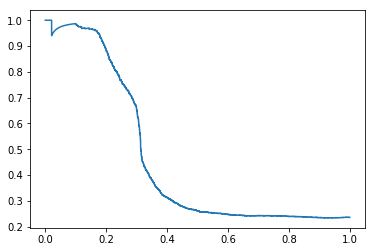

In [56]:
plt.plot( recall, precision )

In [44]:
from sklearn.metrics import average_precision_score

Посмотрим оценку average_precision_score модели - площадь под кривой. 0.46 - пока ни о чем не говорит, надо сравнивать.

In [57]:
average_precision_score( y_test, predictions[:, 1] )

0.460608379745151

In [82]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Посмотрим на ROC кривую

In [60]:
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1] )

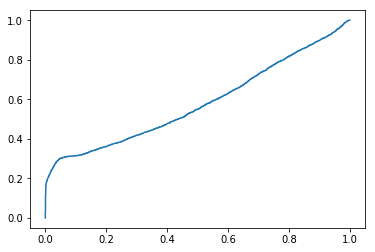

In [61]:
plt.plot( fpr, tpr )

Посмотрим на оценку ROC AUC

In [84]:
roc_auc_score( y_test, predictions[:, 1] )

0.5801866921377254

Обучим на том же датасете дерево решений, предварительно пропустив через grid search для нахождения оптимальной глубины

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [63]:
depths = np.arange(1,10)
grid = {'max_depth': depths}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='accuracy', cv=5)

In [64]:
%%time
gridsearch.fit(X_train, y_train)

Wall time: 5.47 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [65]:
gridsearch.best_params_

{'max_depth': 8}

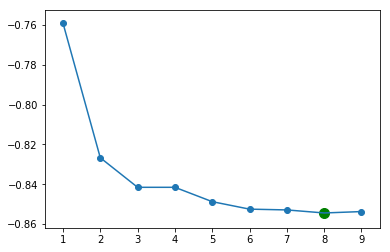

In [66]:
scores = [-x for x in gridsearch.cv_results_['mean_test_score']]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

In [67]:
model2 = DecisionTreeClassifier(max_depth=8)

In [68]:
model2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

R^2 больше, видим, что модель скорее всего лучше предыдущей

In [86]:
model2.score(X_test, y_test)

0.8613351532448195

In [70]:
predictions2 = model2.predict_proba(X_test)

In [71]:
precision2, recall2, thresholds2 = precision_recall_curve( y_test, predictions2[:, 1] )

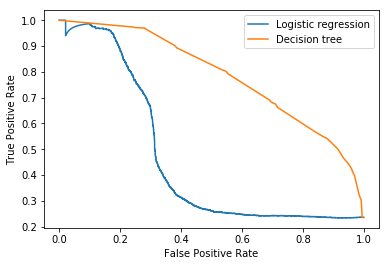

In [73]:
plt.plot( recall, precision, label = 'Logistic regression' )
plt.plot( recall2, precision2, label = 'Decision tree' )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend( loc = 0 )
plt.show()

По виду кривой precision-recall и показателю average_precision_score вторая модель лучше первой

In [74]:
average_precision_score( y_test, predictions2[:, 1] )

0.7588895729492835

In [77]:
fpr2, tpr2, thres2 = roc_curve( y_test, predictions2[:, 1] )

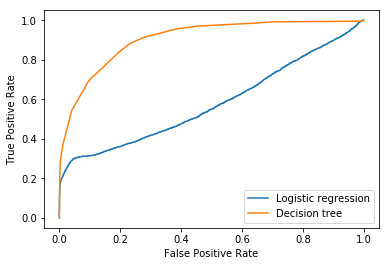

In [78]:
plt.plot( fpr, tpr, label = 'Logistic regression' )
plt.plot( fpr2, tpr2, label = 'Decision tree' )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend( loc = 0 )
plt.show()

In [88]:
roc_auc_score( y_test, predictions2[:, 1] )

0.9053468743224835

По виду кривой ROC и показателю roc auc так же видим, что дерево решений с глубиной 8 почти в два раза лучше, чем логистическая регрессия